In [1]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey as jkey

from training_cnn import single_prediction
from architectures import *

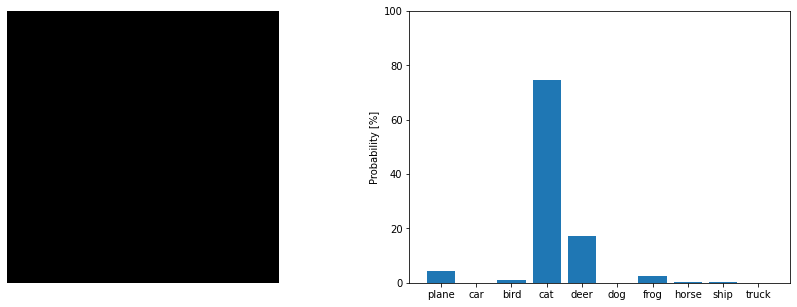

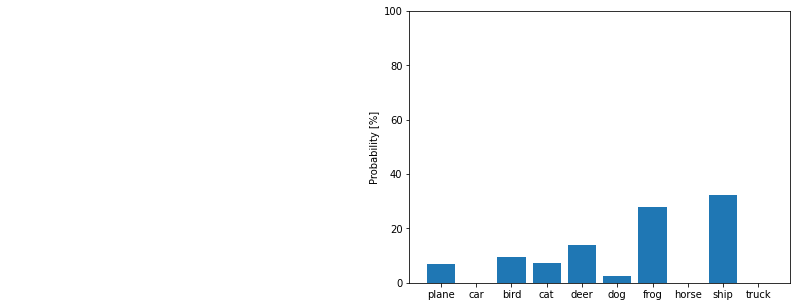

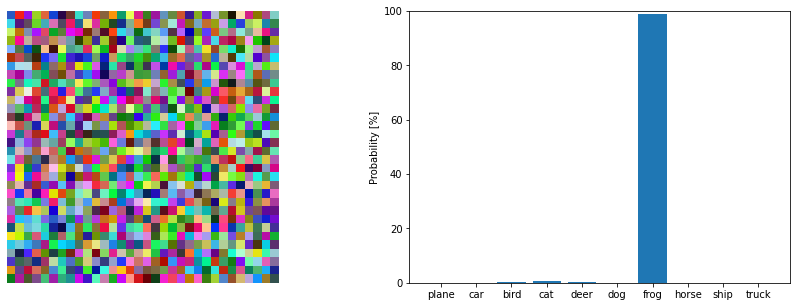

In [3]:
single_prediction(IMG_BLACK, GAP_MODEL, verbose=True)
single_prediction(IMG_WHITE, GAP_MODEL, verbose=True)
single_prediction(IMG_RANDOM, GAP_MODEL, verbose=True);